<a href="https://colab.research.google.com/github/antagonisuto/thesis-code/blob/main/10x101xEEGmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run it

In [1]:
pip install mne

     |████████████████████████████████| 7.5 MB 15.4 MB/s 


In [2]:
import os
import numpy as np
import mne

from sklearn.preprocessing import MinMaxScaler, StandardScaler

#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Visual
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, corrmap)
from scipy.stats import ttest_rel
from tensorflow.keras import utils as np_utils
from sklearn.utils import shuffle
import seaborn as sns

#CNN
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import keras
from keras import layers

In [3]:
dataPath = '/content/drive/MyDrive/databbci/data14'

In [4]:
active_vis = []
passive_vis = []
cue_vis = []

active_au = []
passive_au = []
cue_au = []


for dir in os.listdir(dataPath):
  for filename in os.listdir(os.path.join(dataPath, dir)):
    #if filename.endswith(".vhdr"):
    tmp = os.path.join(os.path.join(dataPath, dir), filename)
      #with open(os.path.join(os.path.join(dataPath, dir), filename), 'r') as f: # open in readonly mode
    # print(filename)
    if filename.endswith("1_active.vhdr"):
      active_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("1_passive.vhdr"):
      passive_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("2_cue.vhdr"):
      cue_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))

    elif filename.endswith("3_active.vhdr"):
      active_au.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("3_passive.vhdr"):
      passive_au.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("4_cue.vhdr"):
      cue_au.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))

<ipython-input-4-ea2d3398f028>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-ea2d3398f028>:17: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  active_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-ea2d3398f028>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-ea2d3398f028>:26: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive_au.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-ea2d3398f028>:24: RuntimeWarning: Online software filter detected. Using soft

In [5]:
print(len(cue_vis), len(cue_au))

14 14


# Function | Run All

    func: raw_to_data(raw, non_active = 0) 
    * active = 0
    * passive = 1
    * cue = 2
    return X, y

\-

    def get_train_test(act, pas, cue): 
    * active[subject] -> act
    * call function "raw_to_data"
    return train_X, test_X, train_y, test_y

\- LDA

  
    def lda_101(train_X, test_X, train_y, test_y):
    return clf, cm

\- CNN

    def cnn_101(train_X, test_X, train_y, test_y):
    * batch_size = 16
    * epochs = 100
    * num_classes = 2
    return cnn_model, cnn_train, test_eval, cm_cnn


\- Visualization

    def vis_confusion_matrix(cm):
    * plot 


## All data load

In [17]:
def raw_to_data(raw, non_active = 0):
  # raw.pick_channels(['C1', 'Fz', 'C2', 'F3', 'F4', 'Pz', 'Oz', 'C3', 'Cz', 'C4'])
  raw.filter(l_freq=0.4, h_freq=40, fir_design='firwin', verbose=False)
  #raw.filter(l_freq=0.4, h_freq=40, method = 'iir', verbose=False)

  events, _ = mne.events_from_annotations(raw, verbose=False)
  tmin, tmax = -0., 1.  # in s
  baseline = (0, 0)

  #passive -> ignore 
  #cue -> active
  # -> active, ignore
  event_dict = {'active': 1, 'ignore': 2}
  if non_active != 0:
    event_dict.clear()
    if non_active == 1: #passive
      event_dict = {'ignore': 2}
    else: # cue
      event_dict = {'active': 1}
  
  epochs = mne.Epochs(
    raw, events=events,
    event_id=event_dict, tmin=tmin,
    tmax=tmax, baseline=baseline, preload = True, verbose=False)
  # print(epochs.events.size)
  # print(epochs.event_id)
  # {'active': 1, 'ignore': 2}

  #preprocessing
  # filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
  # ica = ICA(n_components=10, max_iter='auto', random_state=97)
  # ica.fit(epochs)

  X = epochs.get_data()*1000  # MEG signals: n_epochs, n_meg_channels, n_times
  y = epochs.events[:, 2]  # target: auditory left vs visual left
  #print(X.shape, y.shape)

  return X, y

## Preprocessing

In [18]:
def get_train_test(act, pas, cue):
  # subject = 0
  train_X, train_y = raw_to_data(act, 0)
  pas_X, pas_y = raw_to_data(pas, 1) #passive = 1
  cue_X, cue_y = raw_to_data(cue, 2) #ignore = 2

  test_X = np.append(cue_X, pas_X, axis = 0)
  test_y = np.append(cue_y, pas_y, axis = 0)
  # test_X, test_y = shuffle(test_X, test_y, random_state=10)

  # train_X = train_X[:,:,:100]
  # test_X = test_X[:,:,:100]

  # all_data = np.append(train_X, test_X, axis = 0)
  # all_data_labels = np.append(train_y, test_y, axis = 0)

  # train_X, test_X, train_y, test_y = train_test_split(all_data, all_data_labels, test_size=0.2, random_state=42)

  return train_X, test_X, train_y, test_y


In [19]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

In [20]:
def encoder(X_train, X_test, y_train, y_test):
  # number of input columns
  # n_inputs = X_train.shape[1]
  # split into train test sets
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
  # scale data
  # t = MinMaxScaler()
  # t.fit(X_train)
  # X_train = t.transform(X_train)
  # X_test = t.transform(X_test)
  # define encoder
  # visible = Input(shape=(n_inputs, 101))
  # encoder level 1

  input = keras.Input(shape=(10, 100, 1))

  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  # x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional

  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  # x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  decoded = layers.Conv2D(1, (3, 1), activation='sigmoid')(x)
  autoencoder = keras.Model(input, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  # # output layer
  # output = Dense(n_inputs, activation='linear')(d)
  # # define autoencoder model
  # model = Model(inputs=visible, outputs=output)
  # # compile autoencoder model
  # model.compile(optimizer='adam', loss='mse')
  # # plot the autoencoder
  plot_model(autoencoder, 'autoencoder_compress.png', show_shapes=True)
  return autoencoder

## LDA Function

In [21]:
def lda_101(train_X, test_X, train_y, test_y):
  n = train_X.shape[0]
  train_lda = train_X.reshape(n,-1)
  n = test_X.shape[0]
  test_lda = test_X.reshape(n, -1)

  clf = LDA()
  clf.fit(train_lda, train_y)

  y_pred = clf.predict(test_lda)
  cm = confusion_matrix(test_y, y_pred)
  print(cm)
  print('Accuracy' + str(accuracy_score(test_y, y_pred)))

  return clf, cm

## CNN Functions

In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8
#
# Montserrat Alvarado <amontserrat@gmail.com> / Gibran Fuentes-Pineda <gibranfp@unam.mx>
# DMAS-UAM / IIMAS-UNAM
# 2019
#
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

def cecotti_normal(shape, dtype = None, partition_info = None):
    '''
    Initializer proposed by Cecotti et al. 2011:
    https://ieeexplore.ieee.org/document/5492691
    '''
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
  
    return K.random_normal(shape, mean = 0.0, stddev = (1.0 / fan_in))

def scaled_tanh(z):
    '''
    Scaled hyperbolic tangent activation function, as proposed
    by Lecun 1989:
    http://yann.lecun.com/exdb/publis/pdf/lecun-89.pdf

    See also Lecun et al. 1998:
    http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf 
    '''
    return 1.7159 * K.tanh((2.0 / 3.0) * z)

get_custom_objects().update({'scaled_tanh': Activation(scaled_tanh)})

def CNN1(Chans = 32, Samples = 101):
    eeg_input    = Input(shape = (Samples, Chans))
    
    block1       = Conv1D(10, 1, padding = 'same',
                          data_format = 'channels_last',
                          bias_initializer = cecotti_normal,
                          kernel_initializer = cecotti_normal,
                          use_bias = True)(eeg_input)
    block1       = Activation('scaled_tanh')(block1)

    block1       = Conv1D(50, 13, padding = 'same',
                          data_format = 'channels_last',
                          bias_initializer = cecotti_normal,
                          kernel_initializer = cecotti_normal,
                          use_bias = True)(block1)
    block1       = Activation('scaled_tanh')(block1)
    
    flatten      = Flatten(name = 'flatten')(block1)
    dense        = Dense(100, activation = 'sigmoid')(flatten)
    prediction   = Dense(2, activation = 'sigmoid')(dense)
    
    return Model(inputs = eeg_input, outputs = prediction, name = 'CNN1')

def UCNN1(Chans = 32, Samples = 101):
    eeg_input    = Input(shape = (Samples, Chans))
    
    block1       = Conv1D(10, 1, padding = 'same',
                          data_format = 'channels_last',
                          bias_initializer = cecotti_normal,
                          kernel_initializer = cecotti_normal,
                          use_bias = True)(eeg_input)
    block1       = Activation('scaled_tanh')(block1)

    block1       = Conv1D(50, 13, padding = 'same',
                          data_format = 'channels_last',
                          bias_initializer = cecotti_normal,
                          kernel_initializer = cecotti_normal,
                          use_bias = True)(block1)
    block1       = Activation('scaled_tanh')(block1)
    
    flatten      = Flatten(name = 'flatten')(block1)
    dense        = Dense(100, activation = 'sigmoid')(flatten)
    dense        = Dense(2)(dense)
    softmax      = Activation('softmax', name = 'softmax')(dense)
        
    return Model(inputs = eeg_input, outputs = softmax, name = 'UCNN1')


In [ ]:
def BN3(Samples = 101, Chans = 32):
    eeg_input   = Input(shape = (Samples, Chans))
    bn_input    = BatchNormalization()(eeg_input)
    block1       = Conv1D(16, 1, strides = 1, padding = 'valid', use_bias = True,
                          data_format = 'channels_last', bias_initializer = 'glorot_uniform', kernel_initializer = 'glorot_uniform')(bn_input)
    block2       = Conv1D(16, 20, strides = 20, padding = 'same', use_bias = True,
                          data_format = 'channels_last', bias_initializer = 'glorot_uniform', kernel_initializer = 'glorot_uniform')(block1)
    block2      = BatchNormalization()(block2)
    block2       = Activation('relu')(block2)
    
    flatten      = Flatten(name = 'flatten')(block2)
    dense1       = Dense(128, activation = 'tanh', bias_initializer = 'glorot_uniform', kernel_initializer = 'glorot_uniform')(flatten)
    dense1       = Dropout(0.8)(dense1)
    dense2       = Dense(128, activation = 'tanh', bias_initializer = 'glorot_uniform', kernel_initializer = 'glorot_uniform')(dense1)
    dense2       = Dropout(0.8)(dense2)
    prediction   = Dense(2, activation = 'sigmoid', bias_initializer = 'glorot_uniform', kernel_initializer = 'glorot_uniform')(dense2)
    
    return Model(inputs = eeg_input, outputs = prediction, name = 'BN3')

In [37]:
def cnn(model, train_X, test_X, train_y, test_y, batch_size = 32, epochs = 100, ver = 1):
  train_X = train_X.reshape(-1, 101, 32)
  test_X = test_X.reshape(-1, 101, 32)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.2, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)
  # batch_size = 32
  # epochs = 100
  num_classes = 2

  # set a valid path for your system to record model checkpoints
  # checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                              #  save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  # opt = SGD(lr=0.01)
  opt = Adam(lr=0.0001, decay=0.01)

  model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=ver,
                          validation_data=(valid_X, valid_label_categorical),
                          # callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  cm_cnn = cm_cnn = metrics.confusion_matrix(y_true=test_y_conv, 
                                              y_pred=pred_y_conv)

  return model, cnn_train, test_eval, cm_cnn


## Get Model

In [30]:
def get_model(name):
  if name == "cnn1":
    model = CNN1()

  if name == "ucnn1":
    model = UCNN1()

  if name == "bn3":
    model = BN3()

  # if name == "enet":
  #   print("okay")
  
  return model

## Visualization Functions

In [25]:
def vis_acc_loss(cnn_train):
  accuracy = cnn_train.history['accuracy']
  val_accuracy = cnn_train.history['val_accuracy']
  loss = cnn_train.history['loss']
  val_loss = cnn_train.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [26]:
def vis_confusion_matrix(cm):


  ax = sns.heatmap(cm, annot=True, 
            fmt='', cmap='Blues')
  
  # group_counts = ["{0:0.0f}".format(value) for value in
  #                 confusion_matrix.flatten()]

  # labels = [f"{v1}\n" for v1 in zip(group_counts)]

  # labels = np.asarray(labels).reshape(2,2)
  
  ax.set_title('CNN Confusion Matrix \n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['NI','AC'])
  ax.yaxis.set_ticklabels(['NI','AC'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()


In [27]:
cnn_models = []
lda_models = []

# All subjects | Auditory

In [32]:
train_X, test_X, train_y, test_y = get_train_test(active_au[0], passive_au[0], cue_au[0])
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(540, 32, 101) (280, 32, 101) (540,) (280,)


In [28]:
res_cnn1 =[]

**************************************************
Subject 0
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 9ms/step - loss: 0.7458 - accuracy: 0.5440 - val_loss: 0.7327 - val_accuracy: 0.2963
Epoch 2/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6947 - accuracy: 0.4722 - val_loss: 0.6733 - val_accuracy: 0.7037
Epoch 3/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6961 - accuracy: 0.4907 - val_loss: 0.6708 - val_accuracy: 0.7037
Epoch 4/200
108/108 [==============================] - 1s 7ms/step - loss: 0.6956 - accuracy: 0.4977 - val_loss: 0.6820 - val_accuracy: 0.7222
Epoch 5/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6966 - accuracy: 0.4815 - val_loss: 0.6845 - val_accuracy: 0.7037
Epoch 6/200
108/108 [==============================] - 1s 7ms/step - loss: 0.6955 - accuracy: 0.5833 - val_loss: 0.6975 - val_accuracy: 0.3796
Epoch 7/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6940 - accuracy: 0.4306 - val_loss: 0.6955 - val_accuracy: 0.4444
Epoch 8/200

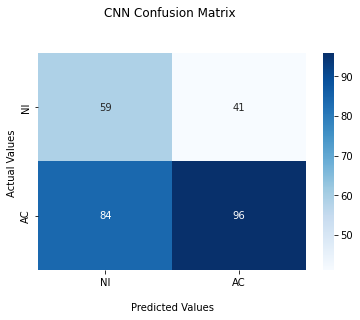

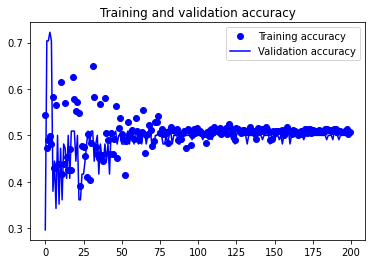

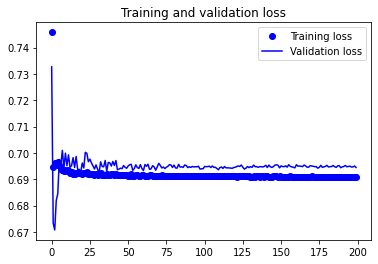

Test loss: 0.6924824118614197
Test accuracy: 0.5535714030265808
**************************************************
**************************************************
Subject 1
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 9ms/step - loss: 0.7296 - accuracy: 0.4190 - val_loss: 0.6830 - val_accuracy: 0.5741
Epoch 2/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6943 - accuracy: 0.5417 - val_loss: 0.7217 - val_accuracy: 0.3333
Epoch 3/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6942 - accuracy: 0.4745 - val_loss: 0.6840 - val_accuracy: 0.6204
Epoch 4/200
108/108 [==============================] - 1s 7ms/step - loss: 0.6967 - accuracy: 0.4444 - val_loss: 0.6738 - val_accuracy: 0.6019
Epoch 5/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6897 - accuracy: 0.5046 - val_loss: 0.7072 - val_accuracy: 0.4630
Epoch 6/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6891 - accuracy: 0.5231 - val_loss: 0.6885 - val_accuracy: 0.6204
Epoch 7/200
108/108 [==============================] - 1s 7ms/step - loss: 0.6881 - accuracy: 0.5417 - val_loss: 0.6802 - val_accuracy: 0.6111
Epoch 8/200

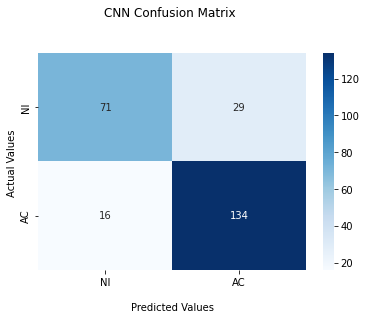

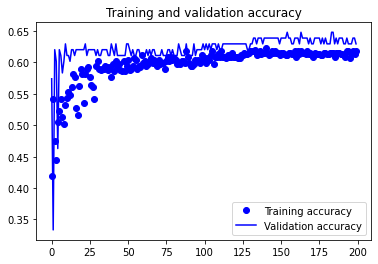

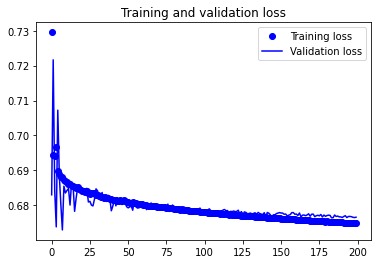

Test loss: 0.6487671136856079
Test accuracy: 0.8199999928474426
**************************************************
**************************************************
Subject 2
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 9ms/step - loss: 0.7467 - accuracy: 0.5880 - val_loss: 0.6935 - val_accuracy: 0.3796
Epoch 2/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6986 - accuracy: 0.4236 - val_loss: 0.6895 - val_accuracy: 0.6296
Epoch 3/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6970 - accuracy: 0.5023 - val_loss: 0.6796 - val_accuracy: 0.6296
Epoch 4/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6983 - accuracy: 0.6227 - val_loss: 0.7164 - val_accuracy: 0.3704
Epoch 5/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6977 - accuracy: 0.3681 - val_loss: 0.6889 - val_accuracy: 0.6296
Epoch 6/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6946 - accuracy: 0.5370 - val_loss: 0.6895 - val_accuracy: 0.6296
Epoch 7/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6953 - accuracy: 0.4537 - val_loss: 0.6880 - val_accuracy: 0.6296
Epoch 8/200

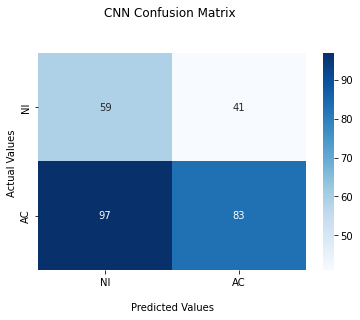

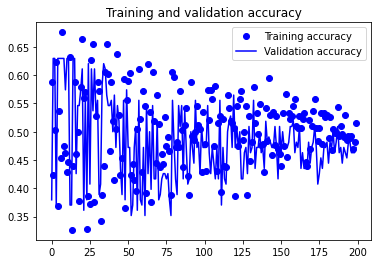

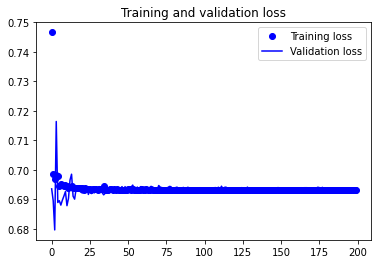

Test loss: 0.6920468211174011
Test accuracy: 0.5071428418159485
**************************************************
**************************************************
Subject 3
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 10ms/step - loss: 0.7016 - accuracy: 0.5556 - val_loss: 0.7194 - val_accuracy: 0.3796
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.7002 - accuracy: 0.3264 - val_loss: 0.6837 - val_accuracy: 0.6204
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6953 - accuracy: 0.6435 - val_loss: 0.6890 - val_accuracy: 0.6204
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6949 - accuracy: 0.3796 - val_loss: 0.6884 - val_accuracy: 0.6204
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6954 - accuracy: 0.6019 - val_loss: 0.6929 - val_accuracy: 0.5926
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6954 - accuracy: 0.4491 - val_loss: 0.6916 - val_accuracy: 0.6204
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6941 - accuracy: 0.6319 - val_loss: 0.6926 - val_accuracy: 0.6204
Epoch 8

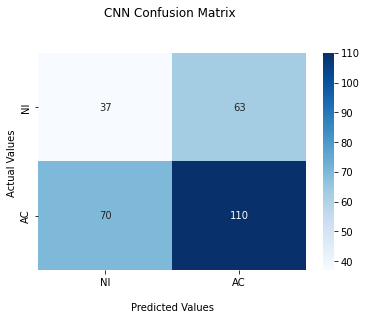

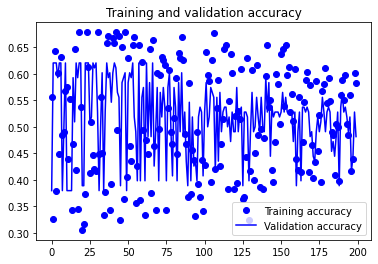

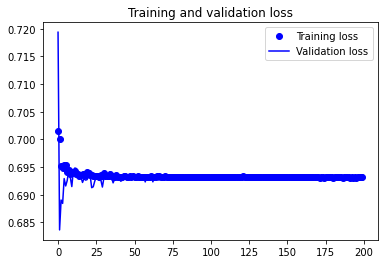

Test loss: 0.6930903196334839
Test accuracy: 0.5249999761581421
**************************************************
**************************************************
Subject 4
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 10ms/step - loss: 0.7205 - accuracy: 0.4838 - val_loss: 0.6692 - val_accuracy: 0.6667
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6989 - accuracy: 0.4699 - val_loss: 0.6801 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6966 - accuracy: 0.4167 - val_loss: 0.6855 - val_accuracy: 0.6481
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6952 - accuracy: 0.6019 - val_loss: 0.7028 - val_accuracy: 0.3333
Epoch 5/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6951 - accuracy: 0.3750 - val_loss: 0.6937 - val_accuracy: 0.5463
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6947 - accuracy: 0.3889 - val_loss: 0.6878 - val_accuracy: 0.6389
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6946 - accuracy: 0.5463 - val_loss: 0.6905 - val_accuracy: 0.6481
Epoch 8/20

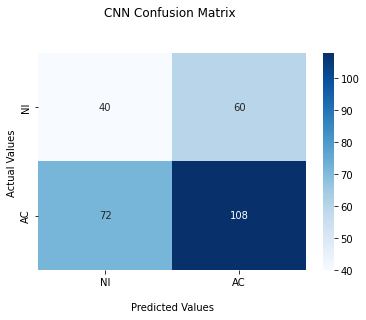

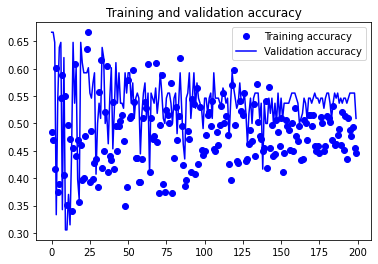

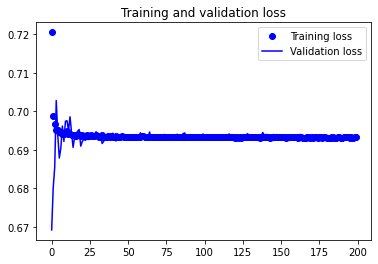

Test loss: 0.6925528645515442
Test accuracy: 0.5285714268684387
**************************************************
**************************************************
Subject 5
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 12ms/step - loss: 0.6960 - accuracy: 0.3981 - val_loss: 0.6911 - val_accuracy: 0.6667
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6952 - accuracy: 0.5486 - val_loss: 0.6904 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6945 - accuracy: 0.4560 - val_loss: 0.6922 - val_accuracy: 0.6667
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6936 - accuracy: 0.6667 - val_loss: 0.6889 - val_accuracy: 0.6667
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6933 - accuracy: 0.5440 - val_loss: 0.6942 - val_accuracy: 0.3333
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6933 - accuracy: 0.6111 - val_loss: 0.6935 - val_accuracy: 0.3796
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6933 - accuracy: 0.5347 - val_loss: 0.6923 - val_accuracy: 0.6574
Epoch 8

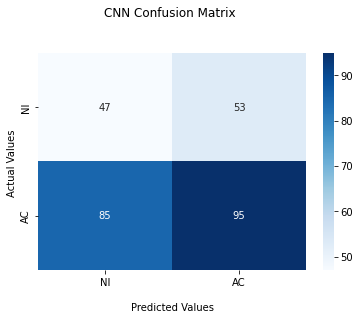

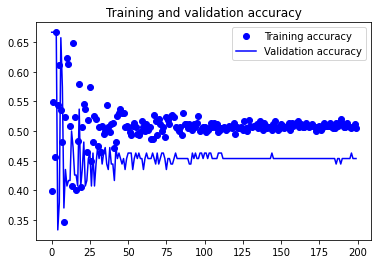

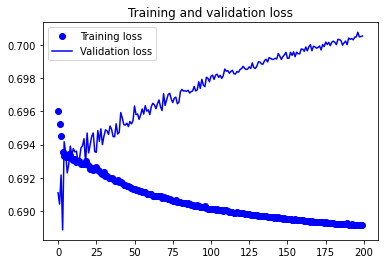

Test loss: 0.6931700706481934
Test accuracy: 0.5071428418159485
**************************************************
**************************************************
Subject 6
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 9ms/step - loss: 0.7697 - accuracy: 0.4306 - val_loss: 0.7328 - val_accuracy: 0.3056
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6966 - accuracy: 0.4676 - val_loss: 0.6676 - val_accuracy: 0.6944
Epoch 3/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6950 - accuracy: 0.5463 - val_loss: 0.7213 - val_accuracy: 0.3056
Epoch 4/200
108/108 [==============================] - 1s 8ms/step - loss: 0.6951 - accuracy: 0.3704 - val_loss: 0.6948 - val_accuracy: 0.4722
Epoch 5/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6943 - accuracy: 0.4722 - val_loss: 0.6692 - val_accuracy: 0.6944
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6967 - accuracy: 0.5116 - val_loss: 0.6873 - val_accuracy: 0.6852
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6955 - accuracy: 0.5139 - val_loss: 0.7007 - val_accuracy: 0.2963
Epoch 8/200

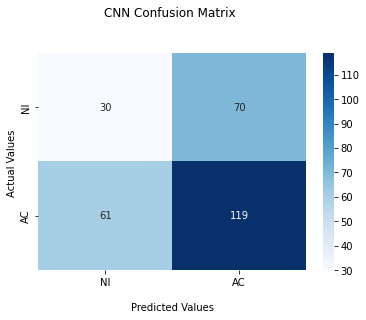

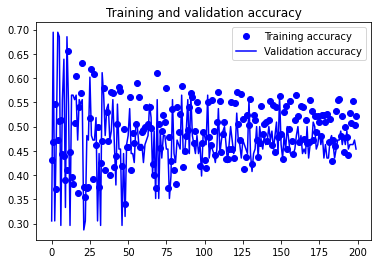

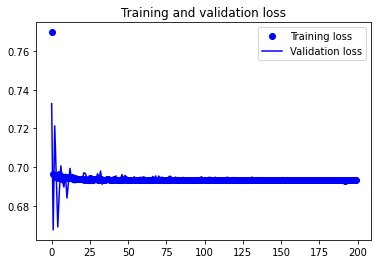

Test loss: 0.6931087970733643
Test accuracy: 0.5321428775787354
**************************************************
**************************************************
Subject 7
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 10ms/step - loss: 0.6979 - accuracy: 0.4144 - val_loss: 0.6980 - val_accuracy: 0.3241
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6942 - accuracy: 0.5671 - val_loss: 0.7032 - val_accuracy: 0.3241
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6945 - accuracy: 0.4236 - val_loss: 0.7002 - val_accuracy: 0.3241
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6939 - accuracy: 0.3356 - val_loss: 0.6980 - val_accuracy: 0.3241
Epoch 5/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6940 - accuracy: 0.3356 - val_loss: 0.6979 - val_accuracy: 0.3241
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6934 - accuracy: 0.3333 - val_loss: 0.6953 - val_accuracy: 0.3241
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6934 - accuracy: 0.5231 - val_loss: 0.6938 - val_accuracy: 0.3241
Epoch 8/20

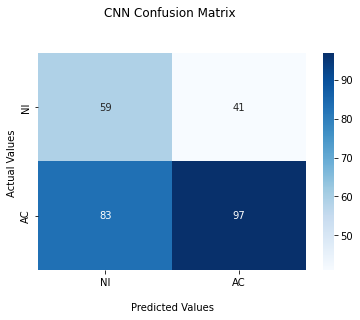

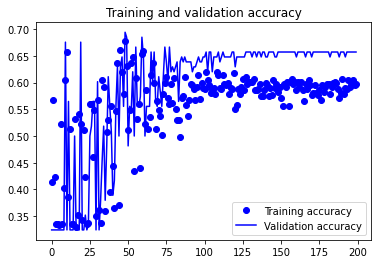

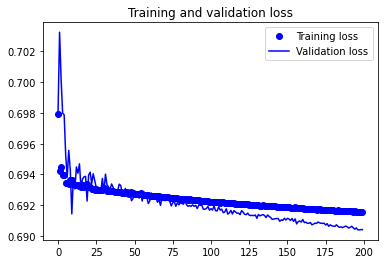

Test loss: 0.6919300556182861
Test accuracy: 0.5571428537368774
**************************************************
**************************************************
Subject 8
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 12ms/step - loss: 0.7143 - accuracy: 0.4560 - val_loss: 0.6677 - val_accuracy: 0.6667
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6947 - accuracy: 0.4861 - val_loss: 0.6586 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6944 - accuracy: 0.5532 - val_loss: 0.7006 - val_accuracy: 0.3333
Epoch 4/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6938 - accuracy: 0.5880 - val_loss: 0.7051 - val_accuracy: 0.3333
Epoch 5/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6940 - accuracy: 0.3333 - val_loss: 0.6942 - val_accuracy: 0.3981
Epoch 6/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6929 - accuracy: 0.4560 - val_loss: 0.6896 - val_accuracy: 0.6389
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6944 - accuracy: 0.5671 - val_loss: 0.7028 - val_accuracy: 0.3333
Epoc

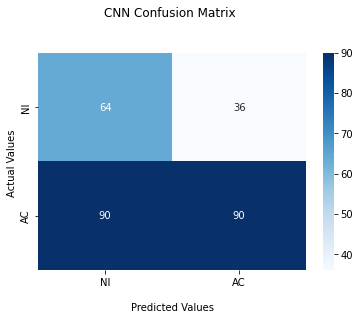

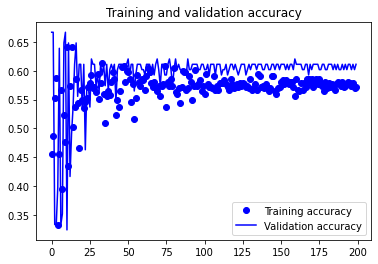

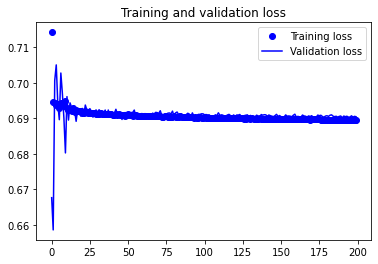

Test loss: 0.6922149062156677
Test accuracy: 0.550000011920929
**************************************************
**************************************************
Subject 9
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.7224 - accuracy: 0.5787 - val_loss: 0.7117 - val_accuracy: 0.3148
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.7007 - accuracy: 0.4491 - val_loss: 0.7114 - val_accuracy: 0.3148
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6960 - accuracy: 0.3380 - val_loss: 0.7054 - val_accuracy: 0.3148
Epoch 4/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6952 - accuracy: 0.5556 - val_loss: 0.7093 - val_accuracy: 0.3148
Epoch 5/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6945 - accuracy: 0.3704 - val_loss: 0.6986 - val_accuracy: 0.3148
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6942 - accuracy: 0.5093 - val_loss: 0.6996 - val_accuracy: 0.3148
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6943 - accuracy: 0.5370 - val_loss: 0.7029 - val_accuracy: 0.3148
Epoch

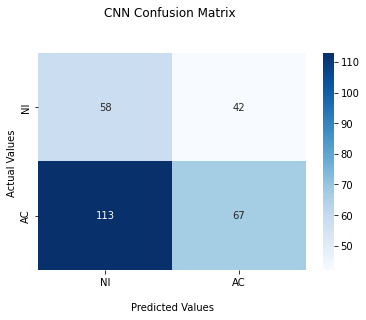

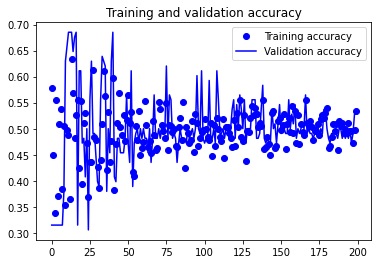

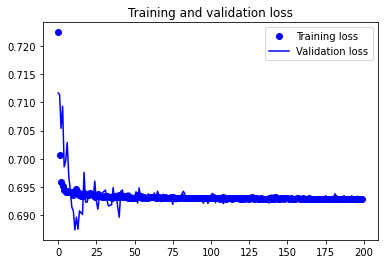

Test loss: 0.6939911246299744
Test accuracy: 0.4464285671710968
**************************************************
**************************************************
Subject 10
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.7259 - accuracy: 0.4769 - val_loss: 0.7068 - val_accuracy: 0.3333
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6947 - accuracy: 0.5718 - val_loss: 0.7129 - val_accuracy: 0.3333
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6948 - accuracy: 0.3981 - val_loss: 0.6891 - val_accuracy: 0.6667
Epoch 4/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6958 - accuracy: 0.6644 - val_loss: 0.6894 - val_accuracy: 0.6667
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6957 - accuracy: 0.5231 - val_loss: 0.7021 - val_accuracy: 0.3333
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6943 - accuracy: 0.4259 - val_loss: 0.6974 - val_accuracy: 0.3333
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6941 - accuracy: 0.4907 - val_loss: 0.6919 - val_accuracy: 0.6667
Epoch

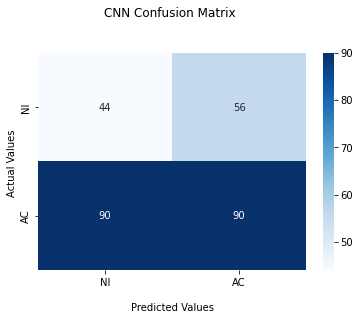

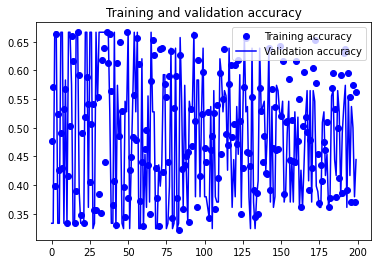

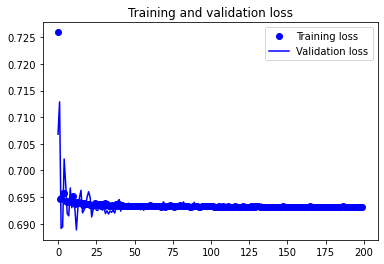

Test loss: 0.6931295990943909
Test accuracy: 0.47857141494750977
**************************************************
**************************************************
Subject 11
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.6955 - accuracy: 0.5185 - val_loss: 0.6891 - val_accuracy: 0.6667
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6943 - accuracy: 0.4259 - val_loss: 0.6928 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6938 - accuracy: 0.5671 - val_loss: 0.6928 - val_accuracy: 0.6296
Epoch 4/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6935 - accuracy: 0.5417 - val_loss: 0.6916 - val_accuracy: 0.6852
Epoch 5/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6933 - accuracy: 0.6458 - val_loss: 0.6931 - val_accuracy: 0.4444
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6930 - accuracy: 0.6366 - val_loss: 0.6920 - val_accuracy: 0.6667
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6933 - accuracy: 0.4144 - val_loss: 0.6917 - val_accuracy: 0.6667
Epoc

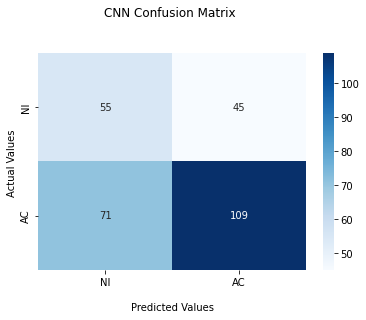

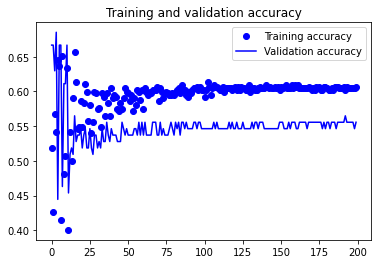

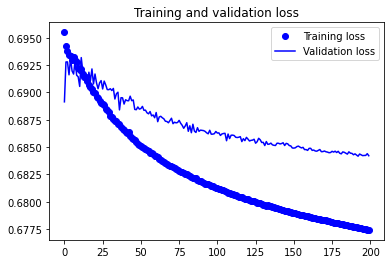

Test loss: 0.6792553663253784
Test accuracy: 0.5857142806053162
**************************************************
**************************************************
Subject 12
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.7110 - accuracy: 0.4005 - val_loss: 0.6807 - val_accuracy: 0.6574
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6944 - accuracy: 0.4282 - val_loss: 0.6886 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6950 - accuracy: 0.6759 - val_loss: 0.6947 - val_accuracy: 0.3426
Epoch 4/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6949 - accuracy: 0.3611 - val_loss: 0.6946 - val_accuracy: 0.3426
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6939 - accuracy: 0.4236 - val_loss: 0.6880 - val_accuracy: 0.6667
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6935 - accuracy: 0.4352 - val_loss: 0.6908 - val_accuracy: 0.6759
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6933 - accuracy: 0.6667 - val_loss: 0.6924 - val_accuracy: 0.5926
Epoch 8/

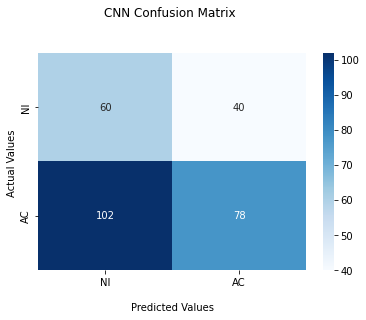

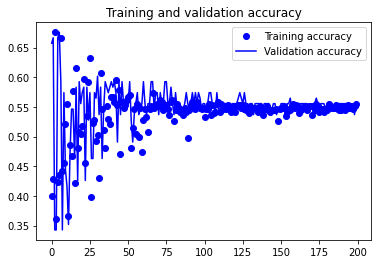

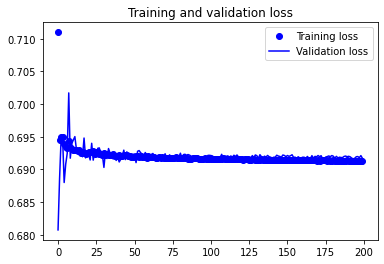

Test loss: 0.6942147016525269
Test accuracy: 0.4928571283817291
**************************************************
**************************************************
Subject 13
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 12ms/step - loss: 0.7034 - accuracy: 0.4097 - val_loss: 0.7136 - val_accuracy: 0.3241
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6957 - accuracy: 0.3866 - val_loss: 0.6957 - val_accuracy: 0.3241
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6966 - accuracy: 0.4931 - val_loss: 0.6983 - val_accuracy: 0.3241
Epoch 4/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6943 - accuracy: 0.3843 - val_loss: 0.6935 - val_accuracy: 0.3426
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6938 - accuracy: 0.6458 - val_loss: 0.6921 - val_accuracy: 0.6759
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6942 - accuracy: 0.4282 - val_loss: 0.6923 - val_accuracy: 0.6759
Epoch 7/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6939 - accuracy: 0.3403 - val_loss: 0.6924 - val_accuracy: 0.6759
Epoc

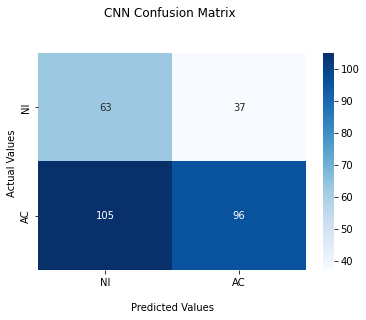

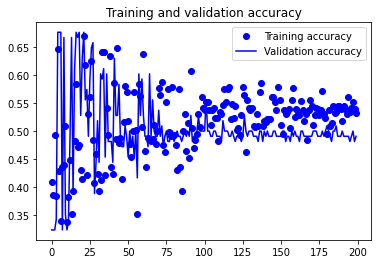

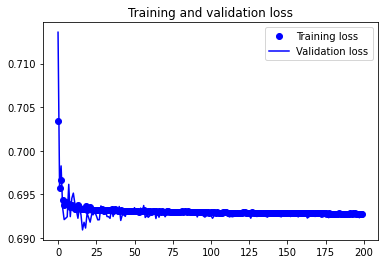

Test loss: 0.6925482153892517
Test accuracy: 0.5282391905784607
**************************************************


In [40]:
for i in range(14):
  print('**************************************************')
  print('Subject', i)
  train_X, test_X, train_y, test_y = get_train_test(active_au[i], passive_au[i], cue_au[i])

  # LDA
  # clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
  # vis_confusion_matrix(cm_lda)

  model = get_model("cnn1")

  #CNN
  cnn_model, cnn_train, test_eval, cm_cnn = cnn(model,
                                                train_X,
                                                test_X,
                                                train_y,
                                                test_y,
                                                batch_size = 4,
                                                epochs = 200,
                                                ver = 1)
  
  vis_confusion_matrix(cm_cnn)
  vis_acc_loss(cnn_train)
  print('Test loss:', test_eval[0])
  print('Test accuracy:', test_eval[1])
  res_cnn1.append(test_eval[1])
  print('**************************************************')

In [47]:
print(np.average(res_cnn1))
print(np.min(res_cnn1))
print(np.max(res_cnn1))

0.5439302245775859
0.4464285671710968
0.8199999928474426


**************************************************
Subject 0
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.6987 - accuracy: 0.5417 - val_loss: 0.6912 - val_accuracy: 0.7037
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6955 - accuracy: 0.4815 - val_loss: 0.6940 - val_accuracy: 0.2963
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6944 - accuracy: 0.6481 - val_loss: 0.6935 - val_accuracy: 0.3519
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6947 - accuracy: 0.4653 - val_loss: 0.6953 - val_accuracy: 0.2963
Epoch 5/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6940 - accuracy: 0.3519 - val_loss: 0.6904 - val_accuracy: 0.7037
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6942 - accuracy: 0.6088 - val_loss: 0.6847 - val_accuracy: 0.7037
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6941 - accuracy: 0.5255 - val_loss: 0.6926 - val_accuracy: 0.6296
Epoch 8/20

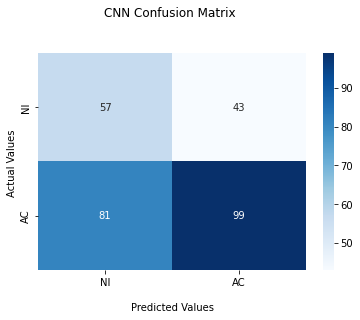

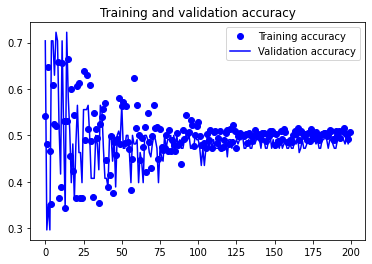

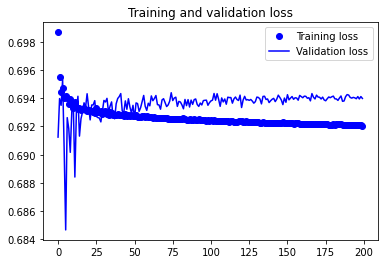

Test loss: 0.6926155686378479
Test accuracy: 0.5571428537368774
**************************************************
**************************************************
Subject 1
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.6954 - accuracy: 0.5880 - val_loss: 0.7520 - val_accuracy: 0.2963
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6906 - accuracy: 0.4583 - val_loss: 0.6641 - val_accuracy: 0.7037
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5139 - val_loss: 0.6815 - val_accuracy: 0.5833
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6916 - accuracy: 0.6019 - val_loss: 0.6937 - val_accuracy: 0.5185
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6893 - accuracy: 0.5278 - val_loss: 0.6867 - val_accuracy: 0.6296
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6873 - accuracy: 0.5810 - val_loss: 0.6903 - val_accuracy: 0.5463
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6856 - accuracy: 0.5995 - val_loss: 0.6856 - val_accuracy: 0.6296
Epoch 8

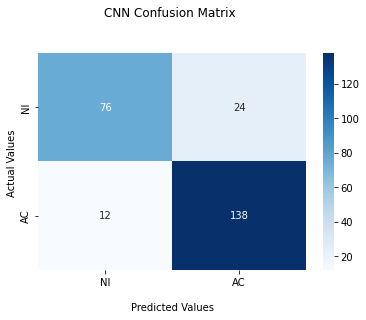

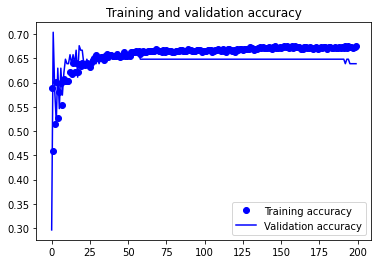

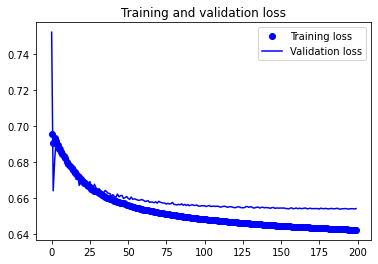

Test loss: 0.5792667865753174
Test accuracy: 0.8560000061988831
**************************************************
**************************************************
Subject 2
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.7016 - accuracy: 0.4977 - val_loss: 0.7111 - val_accuracy: 0.3704
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6962 - accuracy: 0.3773 - val_loss: 0.6855 - val_accuracy: 0.6296
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6975 - accuracy: 0.5324 - val_loss: 0.6894 - val_accuracy: 0.6296
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6955 - accuracy: 0.4769 - val_loss: 0.7031 - val_accuracy: 0.3704
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6972 - accuracy: 0.5532 - val_loss: 0.7093 - val_accuracy: 0.3704
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6953 - accuracy: 0.3333 - val_loss: 0.6925 - val_accuracy: 0.6019
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6944 - accuracy: 0.4491 - val_loss: 0.6933 - val_accuracy: 0.4907
Epoch 8/

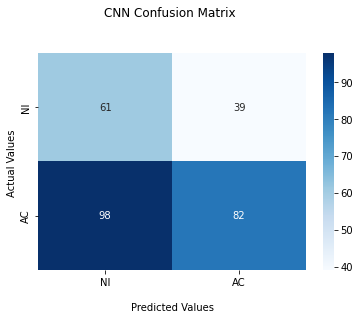

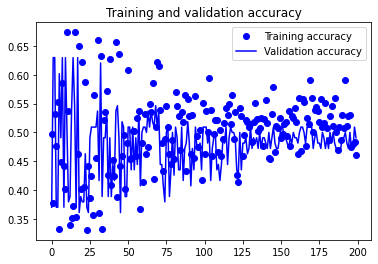

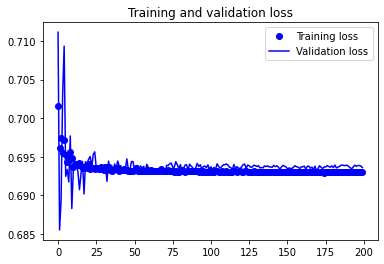

Test loss: 0.6919427514076233
Test accuracy: 0.5107142925262451
**************************************************
**************************************************
Subject 3
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.6968 - accuracy: 0.4606 - val_loss: 0.7021 - val_accuracy: 0.3796
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6943 - accuracy: 0.3218 - val_loss: 0.6933 - val_accuracy: 0.3796
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6943 - accuracy: 0.4398 - val_loss: 0.6928 - val_accuracy: 0.6204
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6941 - accuracy: 0.5023 - val_loss: 0.6925 - val_accuracy: 0.6204
Epoch 5/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6935 - accuracy: 0.3426 - val_loss: 0.6937 - val_accuracy: 0.3796
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6936 - accuracy: 0.3218 - val_loss: 0.6942 - val_accuracy: 0.3796
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6936 - accuracy: 0.3333 - val_loss: 0.6942 - val_accuracy: 0.3796
Epoch 8/2

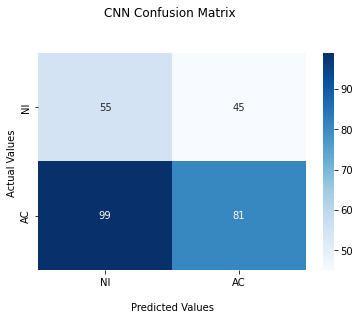

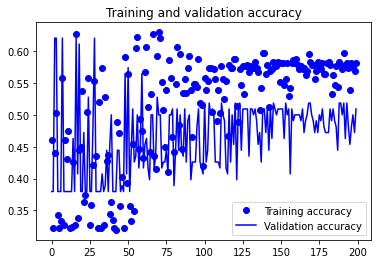

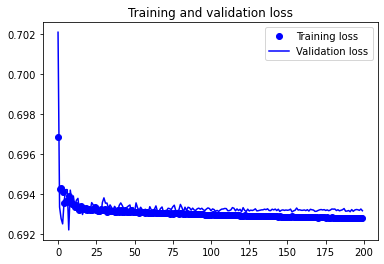

Test loss: 0.6929957866668701
Test accuracy: 0.48571428656578064
**************************************************
**************************************************
Subject 4
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.7001 - accuracy: 0.4560 - val_loss: 0.6966 - val_accuracy: 0.3333
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6955 - accuracy: 0.4074 - val_loss: 0.6820 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6950 - accuracy: 0.5139 - val_loss: 0.6933 - val_accuracy: 0.5278
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6944 - accuracy: 0.5370 - val_loss: 0.7021 - val_accuracy: 0.3333
Epoch 5/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6964 - accuracy: 0.4722 - val_loss: 0.7051 - val_accuracy: 0.3333
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6936 - accuracy: 0.3333 - val_loss: 0.6952 - val_accuracy: 0.3333
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6942 - accuracy: 0.4213 - val_loss: 0.6894 - val_accuracy: 0.6667
Epoch 8/2

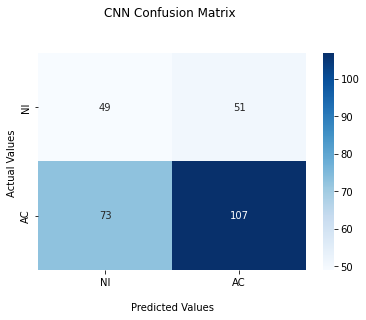

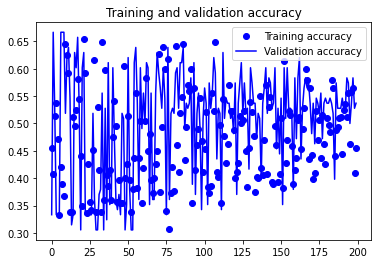

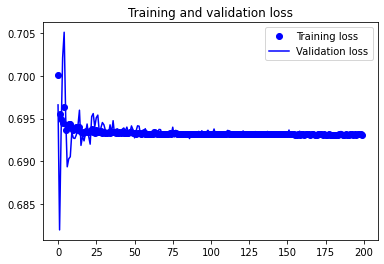

Test loss: 0.6929616332054138
Test accuracy: 0.5571428537368774
**************************************************
**************************************************
Subject 5
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.6975 - accuracy: 0.5648 - val_loss: 0.7045 - val_accuracy: 0.3333
Epoch 2/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6952 - accuracy: 0.4097 - val_loss: 0.6880 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6945 - accuracy: 0.4954 - val_loss: 0.6884 - val_accuracy: 0.6667
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6938 - accuracy: 0.4954 - val_loss: 0.6915 - val_accuracy: 0.6667
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6937 - accuracy: 0.6667 - val_loss: 0.6911 - val_accuracy: 0.6667
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6948 - accuracy: 0.6296 - val_loss: 0.6960 - val_accuracy: 0.3333
Epoch 7/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6938 - accuracy: 0.3333 - val_loss: 0.6946 - val_accuracy: 0.3333
Epoch 8/2

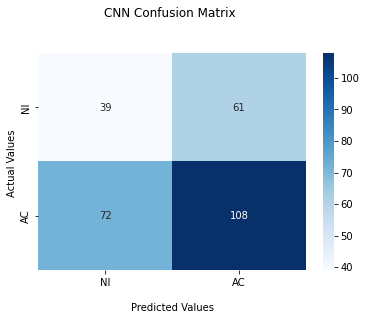

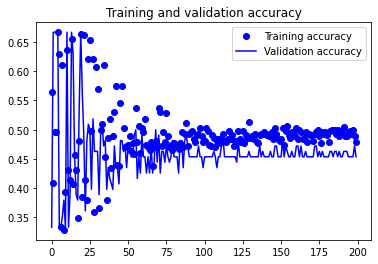

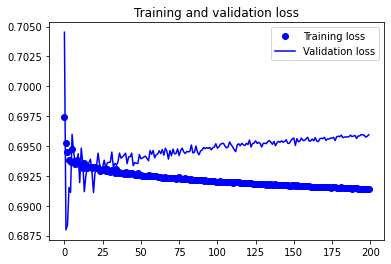

Test loss: 0.6920618414878845
Test accuracy: 0.5249999761581421
**************************************************
**************************************************
Subject 6
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.7101 - accuracy: 0.3843 - val_loss: 0.6994 - val_accuracy: 0.3056
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6971 - accuracy: 0.5532 - val_loss: 0.7153 - val_accuracy: 0.3056
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6958 - accuracy: 0.3796 - val_loss: 0.6967 - val_accuracy: 0.3148
Epoch 4/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6949 - accuracy: 0.5046 - val_loss: 0.7098 - val_accuracy: 0.3056
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6941 - accuracy: 0.3472 - val_loss: 0.6917 - val_accuracy: 0.7037
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6940 - accuracy: 0.6181 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6943 - accuracy: 0.3935 - val_loss: 0.6945 - val_accuracy: 0.3148
Epoc

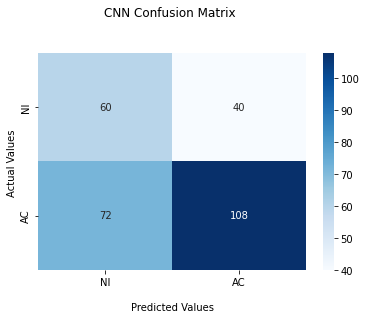

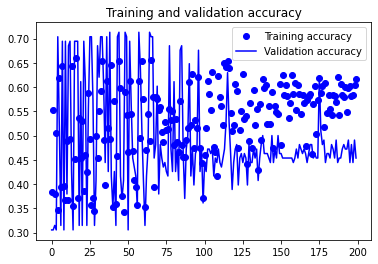

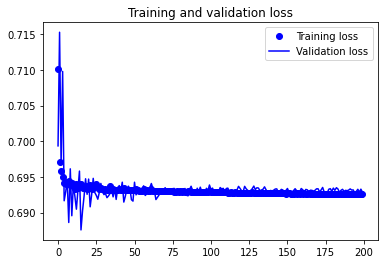

Test loss: 0.6925159692764282
Test accuracy: 0.6000000238418579
**************************************************
**************************************************
Subject 7
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.7226 - accuracy: 0.4653 - val_loss: 0.6904 - val_accuracy: 0.6667
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6967 - accuracy: 0.4815 - val_loss: 0.7085 - val_accuracy: 0.3241
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6942 - accuracy: 0.4074 - val_loss: 0.6761 - val_accuracy: 0.6759
Epoch 4/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6971 - accuracy: 0.5440 - val_loss: 0.6848 - val_accuracy: 0.6759
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6956 - accuracy: 0.4514 - val_loss: 0.6936 - val_accuracy: 0.4722
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6944 - accuracy: 0.5995 - val_loss: 0.6990 - val_accuracy: 0.3241
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6945 - accuracy: 0.3426 - val_loss: 0.6898 - val_accuracy: 0.6667
Epoc

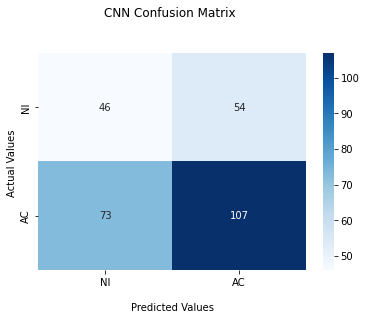

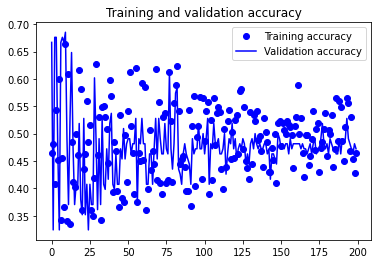

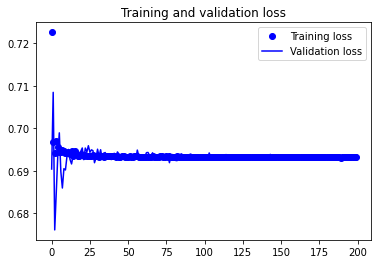

Test loss: 0.6930389404296875
Test accuracy: 0.5464285612106323
**************************************************
**************************************************
Subject 8
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 11ms/step - loss: 0.7022 - accuracy: 0.5046 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6957 - accuracy: 0.3981 - val_loss: 0.6855 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6954 - accuracy: 0.4653 - val_loss: 0.6953 - val_accuracy: 0.3426
Epoch 4/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6962 - accuracy: 0.5116 - val_loss: 0.6984 - val_accuracy: 0.3333
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6938 - accuracy: 0.3796 - val_loss: 0.6967 - val_accuracy: 0.3426
Epoch 6/200
108/108 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.3889 - val_loss: 0.6942 - val_accuracy: 0.4259
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6925 - accuracy: 0.4028 - val_loss: 0.6883 - val_accuracy: 0.6667
Epoch 8

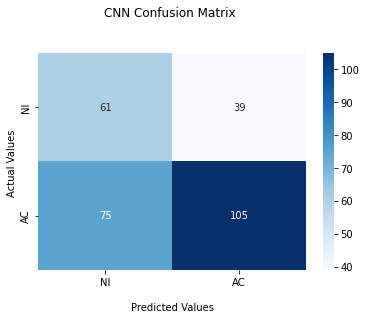

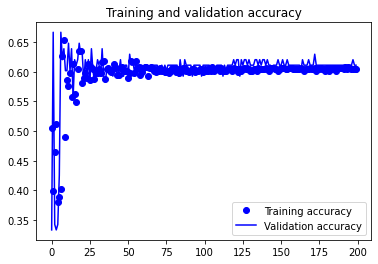

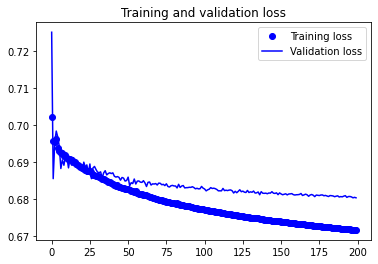

Test loss: 0.6832380294799805
Test accuracy: 0.5928571224212646
**************************************************
**************************************************
Subject 9
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 12ms/step - loss: 0.7148 - accuracy: 0.5324 - val_loss: 0.6874 - val_accuracy: 0.6852
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6963 - accuracy: 0.6296 - val_loss: 0.7093 - val_accuracy: 0.3148
Epoch 3/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6968 - accuracy: 0.3611 - val_loss: 0.7037 - val_accuracy: 0.3148
Epoch 4/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6956 - accuracy: 0.5023 - val_loss: 0.6886 - val_accuracy: 0.6852
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6949 - accuracy: 0.5671 - val_loss: 0.6929 - val_accuracy: 0.5741
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6944 - accuracy: 0.4630 - val_loss: 0.6950 - val_accuracy: 0.3148
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6941 - accuracy: 0.4190 - val_loss: 0.6886 - val_accuracy: 0.6852
Epoc

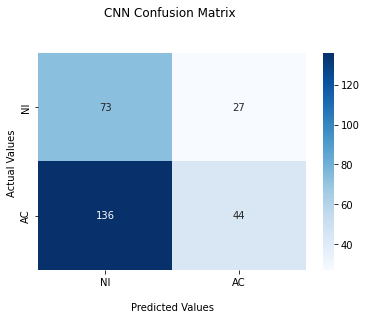

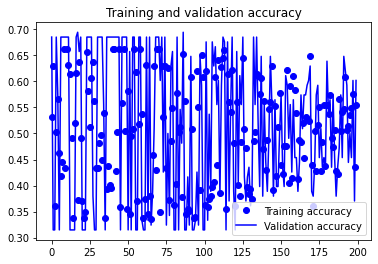

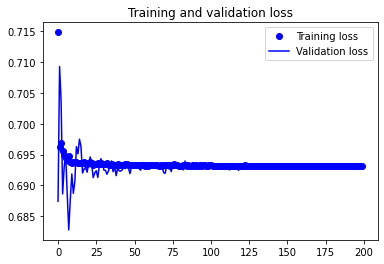

Test loss: 0.6933241486549377
Test accuracy: 0.4178571403026581
**************************************************
**************************************************
Subject 10
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 12ms/step - loss: 0.6989 - accuracy: 0.4838 - val_loss: 0.6960 - val_accuracy: 0.3333
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6960 - accuracy: 0.3843 - val_loss: 0.7009 - val_accuracy: 0.3333
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6946 - accuracy: 0.5926 - val_loss: 0.6923 - val_accuracy: 0.6667
Epoch 4/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6939 - accuracy: 0.3449 - val_loss: 0.6917 - val_accuracy: 0.6667
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6946 - accuracy: 0.5648 - val_loss: 0.6940 - val_accuracy: 0.3333
Epoch 6/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6938 - accuracy: 0.4306 - val_loss: 0.6943 - val_accuracy: 0.3333
Epoch 7/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6938 - accuracy: 0.5764 - val_loss: 0.6964 - val_accuracy: 0.3333
Epoc

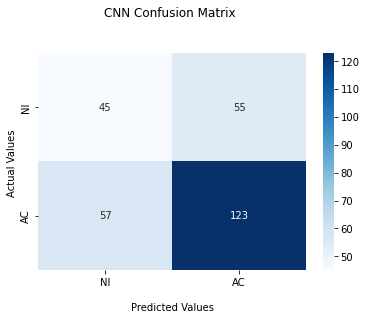

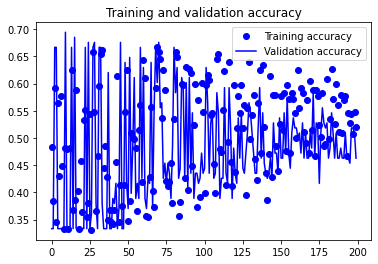

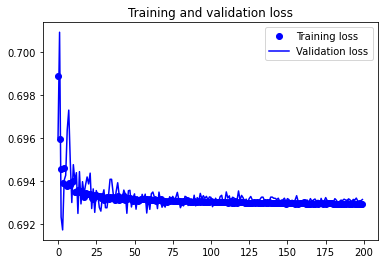

Test loss: 0.6928535103797913
Test accuracy: 0.6000000238418579
**************************************************
**************************************************
Subject 11
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 12ms/step - loss: 0.7152 - accuracy: 0.5046 - val_loss: 0.6838 - val_accuracy: 0.6667
Epoch 2/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6947 - accuracy: 0.4769 - val_loss: 0.6665 - val_accuracy: 0.6667
Epoch 3/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6978 - accuracy: 0.5394 - val_loss: 0.6978 - val_accuracy: 0.3241
Epoch 4/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6961 - accuracy: 0.5532 - val_loss: 0.6955 - val_accuracy: 0.3148
Epoch 5/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6956 - accuracy: 0.3657 - val_loss: 0.6990 - val_accuracy: 0.3241
Epoch 6/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6939 - accuracy: 0.4792 - val_loss: 0.6867 - val_accuracy: 0.6759
Epoch 7/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6935 - accuracy: 0.5231 - val_loss: 0.6890 - val_accuracy: 0.6852
Epoc

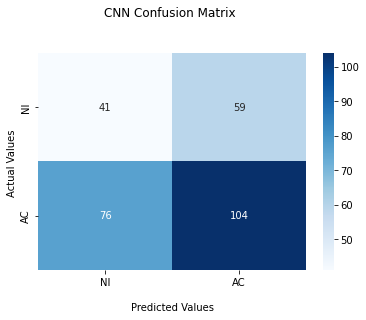

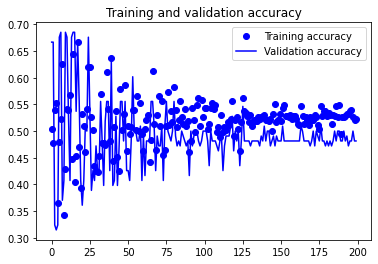

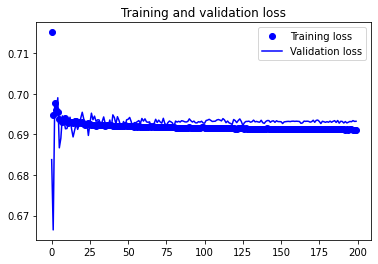

Test loss: 0.6908585429191589
Test accuracy: 0.5178571343421936
**************************************************
**************************************************
Subject 12
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 13ms/step - loss: 0.6973 - accuracy: 0.6690 - val_loss: 0.6946 - val_accuracy: 0.3426
Epoch 2/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6946 - accuracy: 0.5370 - val_loss: 0.6968 - val_accuracy: 0.3426
Epoch 3/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6941 - accuracy: 0.4375 - val_loss: 0.6970 - val_accuracy: 0.3426
Epoch 4/200
108/108 [==============================] - 1s 12ms/step - loss: 0.6937 - accuracy: 0.5903 - val_loss: 0.6927 - val_accuracy: 0.6759
Epoch 5/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6934 - accuracy: 0.3542 - val_loss: 0.6962 - val_accuracy: 0.3426
Epoch 6/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6938 - accuracy: 0.5579 - val_loss: 0.6945 - val_accuracy: 0.3333
Epoch 7/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.3380 - val_loss: 0.6951 - val_accuracy: 0.3333
Epoc

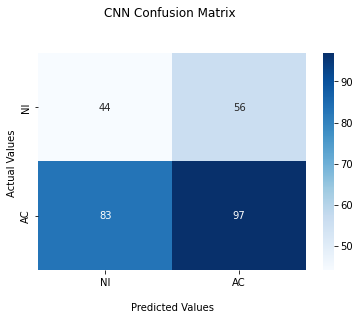

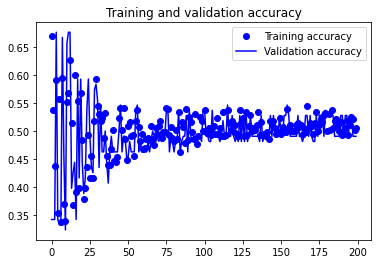

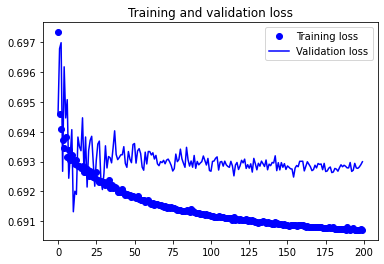

Test loss: 0.693110466003418
Test accuracy: 0.5035714507102966
**************************************************
**************************************************
Subject 13
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


108/108 [==============================] - 2s 12ms/step - loss: 0.7231 - accuracy: 0.4815 - val_loss: 0.7436 - val_accuracy: 0.3241
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.6978 - accuracy: 0.4074 - val_loss: 0.7027 - val_accuracy: 0.3241
Epoch 3/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6956 - accuracy: 0.6111 - val_loss: 0.7069 - val_accuracy: 0.3241
Epoch 4/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6957 - accuracy: 0.3333 - val_loss: 0.6925 - val_accuracy: 0.5556
Epoch 5/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6955 - accuracy: 0.4931 - val_loss: 0.6943 - val_accuracy: 0.4259
Epoch 6/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6944 - accuracy: 0.6366 - val_loss: 0.6961 - val_accuracy: 0.3241
Epoch 7/200
108/108 [==============================] - 1s 11ms/step - loss: 0.6945 - accuracy: 0.3241 - val_loss: 0.6944 - val_accuracy: 0.3611
Epoc

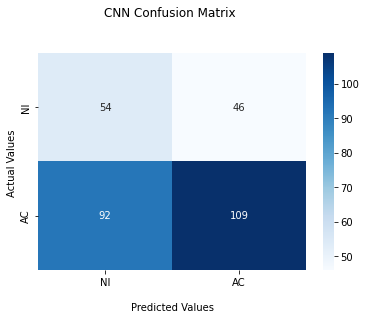

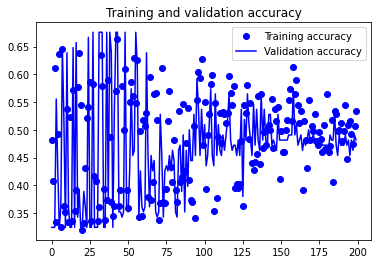

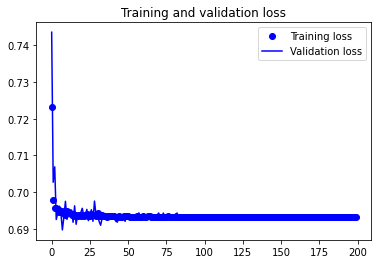

Test loss: 0.692674458026886
Test accuracy: 0.5415282249450684
**************************************************


In [48]:
for i in range(14):
  print('**************************************************')
  print('Subject', i)
  train_X, test_X, train_y, test_y = get_train_test(active_au[i], passive_au[i], cue_au[i])

  # LDA
  # clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
  # vis_confusion_matrix(cm_lda)

  model = get_model("ucnn1")

  #CNN
  cnn_model, cnn_train, test_eval, cm_cnn = cnn(model,
                                                train_X,
                                                test_X,
                                                train_y,
                                                test_y,
                                                batch_size = 4,
                                                epochs = 200,
                                                ver = 1)
  
  vis_confusion_matrix(cm_cnn)
  vis_acc_loss(cnn_train)
  print('Test loss:', test_eval[0])
  print('Test accuracy:', test_eval[1])
  res_cnn1.append(test_eval[1])
  print('**************************************************')

In [49]:
print(np.average(res_cnn1))
print(np.min(res_cnn1))
print(np.max(res_cnn1))

0.5507161144552559
0.4178571403026581
0.8560000061988831
